## <span style="text-decoration : underline">Import packages and datas<span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys, os, json, pickle
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
dbs_path = f'{module_path}/query_dbs/'
models_path = f'{module_path}/models/'
graphs_path =  f'{module_path}/graphs/'

In [3]:
from utils.classif_utils import flatten, multi_label
list_files = os.listdir(dbs_path)
list_query_type = [file_name.replace('.json','') for file_name in list_files if not (file_name in('AllQueriesNoDuplicates.json','.DS_Store','AllQueries.json'))]

In [4]:
datasets = []
for index, query_type in enumerate(list_query_type):
    if index == 3:
        pre_data = json.load(open(dbs_path + query_type + '.json', encoding = 'latin-1'))
    else:
        pre_data = json.load(open(dbs_path +query_type + '.json'))
    datasets.append(pre_data)

In [5]:
new = {list(query_type_dico.keys())[0] : list(query_type_dico.values())[0]  for query_type_dico in datasets}
new = [ {'query_type' : query_type, 'text_full' : flatten(dict_data)} for query_type, data_query_type in new.items()
       for dict_data in data_query_type  ]
data_label = pd.DataFrame(new)

In [6]:
queries = {query_type : index for index, query_type in enumerate(list_query_type)}
data_label['label'] = data_label['query_type'].map(queries) 
data_label.head()

,query_type,text_full,label
0,PlayMusic,I need to hear the song Aspro Mavro from Bill ...,0
1,PlayMusic,play Yo Ho from the new york pops on Youtube,0
2,PlayMusic,Play some seventies music by Janne Puurtinen o...,0
3,PlayMusic,play the Música Da Série De Filmes O Hobbit al...,0
4,PlayMusic,Play Magic Sam from the thirties,0


#### Multilabel target

In [7]:
data_label["label_multi"] = np.nan
data_label["label_multi"] = data_label["label"].apply(multi_label)
data_label.dropna(inplace = True)

### Deep learning model

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

Using TensorFlow backend.


In [9]:
nb_words_max = 50000
max_seq_length = 40
embedding_dim = 100

In [10]:
tokenizer = Tokenizer(num_words=nb_words_max, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_label['text_full'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(data_label['text_full'].values)
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor:', X.shape)

Y = np.vstack(data_label['label_multi'].values)
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

Found 11965 unique tokens.
Shape of data tensor: (14484, 40)
Shape of label tensor: (14484, 8)


In [11]:
# saving tokenizer
with open(f'{models_path}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
model = Sequential()
model.add(Embedding(nb_words_max, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(10, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0005), metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
Total params: 5,004,528
Trainable params: 5,004,528
Non-trainable params: 0
___________

In [13]:
history = model.fit(X_train, Y_train, epochs=10, batch_size= 16, validation_data = (X_test,Y_test))
model.save(f"{models_path}lstm_classif_type.h5")

Instructions for updating:
Use tf.cast instead.
Train on 13035 samples, validate on 1449 samples
Epoch 1/10
13035/13035 [==============================] - 177s 14ms/step - loss: 1.3052 - acc: 0.6063 - val_loss: 0.5495 - val_acc: 0.9386
Epoch 2/10
13035/13035 [==============================] - 184s 14ms/step - loss: 0.4733 - acc: 0.9121 - val_loss: 0.2107 - val_acc: 0.9710
Epoch 3/10
13035/13035 [==============================] - 163s 12ms/step - loss: 0.2563 - acc: 0.9567 - val_loss: 0.1279 - val_acc: 0.9772
Epoch 4/10
13035/13035 [==============================] - 98s 7ms/step - loss: 0.1645 - acc: 0.9723 - val_loss: 0.0950 - val_acc: 0.9814
Epoch 5/10
13035/13035 [==============================] - 95s 7ms/step - loss: 0.1217 - acc: 0.9787 - val_loss: 0.0803 - val_acc: 0.9827
Epoch 6/10
13035/13035 [==============================] - 90s 7ms/step - loss: 0.0934 - acc: 0.9814 - val_loss: 0.0745 - val_acc: 0.9834
Epoch 7/10
13035/13035 [==============================] - 92s 7ms/step - lo

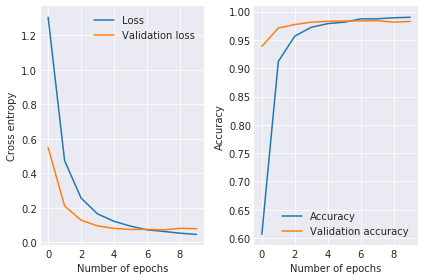

In [15]:
#Plot
plt.style.use("seaborn-darkgrid")
plt.subplot(121)
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Validation loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cross entropy")
plt.legend()

plt.subplot(122)
plt.plot(history.history["acc"], label = "Accuracy")
plt.plot(history.history["val_acc"], label = "Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.legend()
plt.tight_layout()

plt.savefig(f'{graphs_path}loss_accuracy.png')

In [16]:
from utils.classif_utils import plot_confusion_matrix

Confusion matrix, without normalization
[[208   0   0   0   3   0   0]
 [  0 189   0   0   0   0   0]
 [  3   0 206   0   0   0   0]
 [  0   2   0 222   0   0   0]
 [  4   2   0   1 200   4   0]
 [  0   0   0   0   6 200   0]
 [  0   0   0   0   0   0 199]]


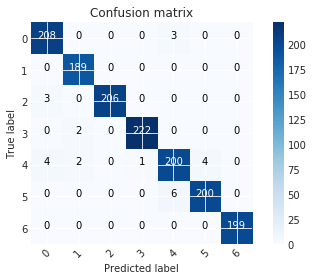

In [18]:
pred = model.predict(X_test)
n = len(X_test)

lab_pred = np.zeros(n)
lab_true = np.zeros(n)

for i in range(n):
    lab_pred[i] = np.argmax(pred[i])
    lab_true[i] = np.argmax(Y_test[i])

plot_confusion_matrix(confusion_matrix(lab_true,lab_pred), classes = np.arange(7))

In [19]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
models_path = f'{module_path}/models/'

In [3]:
from utils.classif_model import predict
import numpy as np

Using TensorFlow backend.


In [16]:
test = ["", "I want to listen to techno music", "Rate Harry Potter movie zero of 6 ", 
        "What will the weather be like tomorow mother fucker ?", 'I want to book a table for six']
test = np.array(test)
predictions  = predict(test)

In [17]:
print(test)
print(predictions)

['' 'I want to listen to techno music'
 'Rate Harry Potter movie zero of 6 '
 'What will the weather be like tomorow mother fucker ?'
 'I want to book a table for six']
['SearchCreativeWork', 'PlayMusic', 'RateBook', 'GetWeather', 'BookRestaurant']


In [18]:
predictions

['SearchCreativeWork', 'PlayMusic', 'RateBook', 'GetWeather', 'BookRestaurant']

In [15]:
print(sys.version)

3.6.3 (default, Oct  4 2017, 06:09:15) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
